In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
data = pd.read_csv('train_hw.csv')

Сразу удаляем технические параметры

In [3]:
data.drop(['Id'], axis = 1, inplace = True)

In [4]:
data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Находим численные и категориальные переменные и смотрим пропущенные значения:

In [5]:
numeric_variable_columns = data.select_dtypes(include = ['int64', 'float64']).columns

In [6]:
numeric_variable_missed = data[numeric_variable_columns].isna().sum().sort_values(ascending = True)
numeric_variable_missed_list = data[numeric_variable_columns].isna().sum().sort_values(ascending = True).index.tolist()
numeric_variable_missed[numeric_variable_missed>0]

MasVnrArea       8
GarageYrBlt     81
LotFrontage    259
dtype: int64

Заполним пропущенные численные значения на -999, чтобы деревья их могли отличить

In [7]:
for i in numeric_variable_missed_list:
    data[i].fillna(-999, inplace = True)

In [8]:
categorial_variable_columns = data.select_dtypes(include = ['object']).columns
categorial_variablem_missed = data[categorial_variable_columns].isna().sum().sort_values(ascending = True)
categorial_variablem_missed_list = data[categorial_variable_columns].isna().sum().sort_values(ascending = True).index.tolist()
categorial_variablem_missed[categorial_variablem_missed > 0]

Electrical         1
MasVnrType         8
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

В категориальных данных очень много пропусков со значением NaN, из документации узнаем, что значение NaN не является пропуском, а является отрицанием (например, для параметра MiscFeature NaN значит, что нет больше никаких дополнительных признаков у объекта). Поэтому заполним пустые значения на отрицающие.

In [9]:
for i in categorial_variablem_missed_list:
    data[i].fillna('none', inplace = True)

In [10]:
data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,none,Reg,Lvl,AllPub,Inside,...,0,none,none,none,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,none,Reg,Lvl,AllPub,FR2,...,0,none,none,none,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,none,IR1,Lvl,AllPub,Inside,...,0,none,none,none,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,none,IR1,Lvl,AllPub,Corner,...,0,none,none,none,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,none,IR1,Lvl,AllPub,FR2,...,0,none,none,none,0,12,2008,WD,Normal,250000


Кодируем категориальные признаки и сохраняем, чтобы при необходимости перекодировать обратно

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [12]:
#кодируем категориальные признаки и сохраняем, чтобы при необходимости перекодировать обратно
storage_label = {}
for elem in list(categorial_variable_columns):
    data[elem] = le.fit_transform(data[elem])
    storage_label.update({elem: le.classes_})

In [78]:
data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,2,3,3,0,4,...,0,3,4,4,0,2,2008,8,4,208500
1,20,3,80.0,9600,1,2,3,3,0,2,...,0,3,4,4,0,5,2007,8,4,181500
2,60,3,68.0,11250,1,2,0,3,0,4,...,0,3,4,4,0,9,2008,8,4,223500
3,70,3,60.0,9550,1,2,0,3,0,0,...,0,3,4,4,0,2,2006,8,0,140000
4,60,3,84.0,14260,1,2,0,3,0,2,...,0,3,4,4,0,12,2008,8,4,250000


Оцениваем важность признаков

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['SalePrice'], axis = 1), data['SalePrice'], test_size=0.3, random_state = 42)  

In [15]:
forest = RandomForestClassifier(random_state = 22)
forest.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=22)

<AxesSubplot:>

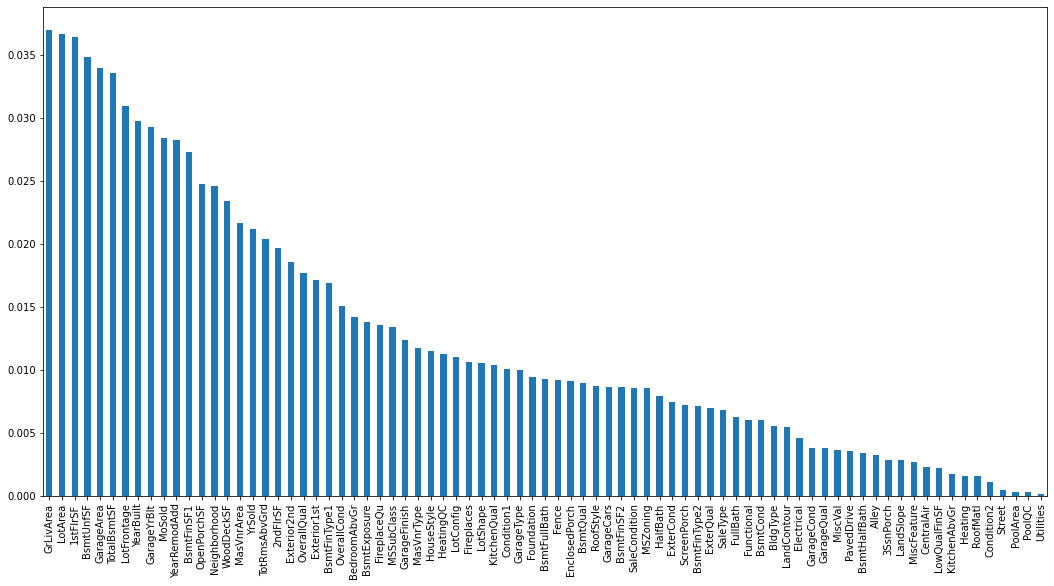

In [16]:
plt.figure(figsize=(18,9))
forest_importances = pd.Series(forest.feature_importances_, index = list(data.columns[:-1]))
forest_importances.sort_values(ascending = False).plot.bar()

Сделаем стекинг из трех моделей

In [34]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV

In [35]:
Regressor = StackingRegressor(
    [
        ('LinearRegression', LinearRegression()),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('DecisionTree', DecisionTreeRegressor())
    ], RidgeCV())

Посмотрим результат на всех признаках

In [37]:
Regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('DecisionTree', DecisionTreeRegressor())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [38]:
print(f'Score on train data {Regressor.score(X_train, y_train)}')
print(f'Score on test data {Regressor.score(X_test, y_test)}')

for i in Regressor.named_estimators:
    print(f'Score on train data with model {i} {Regressor.named_estimators_[i].score(X_train, y_train)}')
    print(f'Score on test data with model {i} {Regressor.named_estimators_[i].score(X_test, y_test)}')


Score on train data 0.9220247400549102
Score on test data 0.8429100034319307
Score on train data with model LinearRegression 0.8489012320372318
Score on test data with model LinearRegression 0.8459061292969314
Score on train data with model KNeighborsRegressor 0.7501837788800589
Score on test data with model KNeighborsRegressor 0.676377213960007
Score on train data with model DecisionTree 1.0
Score on test data with model DecisionTree 0.8063474224381769


### Деревья решений на трейн выборке вероятнее всего переобучились, К-ближайщих соседей недообучилась, линейная регрессия справилась лучше всего

Если оставить только признаки со значимостью более 0.015

In [61]:
feature_forest_0015 = forest_importances[forest_importances>0.015].index.tolist()
feature_forest_0015

['LotFrontage',
 'LotArea',
 'Neighborhood',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrArea',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'MoSold',
 'YrSold']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_forest_0015], data['SalePrice'], test_size=0.3, random_state = 42)  

In [58]:
Regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('DecisionTree', DecisionTreeRegressor())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [59]:
print(f'Score on train data {Regressor.score(X_train, y_train)}')
print(f'Score on test data {Regressor.score(X_test, y_test)}')

for i in Regressor.named_estimators:
    print(f'Score on train data with model {i} {Regressor.named_estimators_[i].score(X_train, y_train)}')
    print(f'Score on test data with model {i} {Regressor.named_estimators_[i].score(X_test, y_test)}')


Score on train data 0.8920951335951245
Score on test data 0.8510698863731756
Score on train data with model LinearRegression 0.7755642557149701
Score on test data with model LinearRegression 0.8251523405572582
Score on train data with model KNeighborsRegressor 0.7451672339318016
Score on test data with model KNeighborsRegressor 0.679423546188664
Score on train data with model DecisionTree 0.9999944000830953
Score on test data with model DecisionTree 0.8159163892112619


### В целом результат такой же, только на тестовой выборке стекинг обучился чуть лучше

Если оставить только признаки со значимостью более 0.025

In [63]:
feature_forest_0025 = forest_importances[forest_importances>0.025].index.tolist()
feature_forest_0025

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'MoSold']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_forest_0025], data['SalePrice'], test_size=0.3, random_state = 42)  

In [65]:
Regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('DecisionTree', DecisionTreeRegressor())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [66]:
print(f'Score on train data {Regressor.score(X_train, y_train)}')
print(f'Score on test data {Regressor.score(X_test, y_test)}')

for i in Regressor.named_estimators:
    print(f'Score on train data with model {i} {Regressor.named_estimators_[i].score(X_train, y_train)}')
    print(f'Score on test data with model {i} {Regressor.named_estimators_[i].score(X_test, y_test)}')


Score on train data 0.8692104681000817
Score on test data 0.8038528436204235
Score on train data with model LinearRegression 0.7106153653900562
Score on test data with model LinearRegression 0.7757798441241401
Score on train data with model KNeighborsRegressor 0.7526030174686424
Score on test data with model KNeighborsRegressor 0.6801681058368315
Score on train data with model DecisionTree 0.9999944000830953
Score on test data with model DecisionTree 0.7205817292788264
